In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import tqdm

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data preprocessing
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [3]:
# Load the Food101 dataset
train_dataset = datasets.Food101(root="./data", split="train", transform=data_transforms["train"], download=True)
val_dataset = datasets.Food101(root="./data", split="test", transform=data_transforms["val"], download=True)

In [4]:
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8),
    "val": DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8),
}

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}
class_names = train_dataset.classes

In [5]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

model = model.to(device)

/home/aleksandr-vashchenko/Desktop/Food101/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandr-vashchenko/Desktop/Food101/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [7]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

# Save the model
torch.save(model.state_dict(), "resnet18_food101_transfer_learning.pth")
print("Model saved!")

Epoch 1/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.72it/s]


train Loss: 3.0024 Acc: 0.3284


100%|██████████| 198/198 [00:13<00:00, 15.01it/s]


val Loss: 1.9811 Acc: 0.5193

Epoch 2/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.78it/s]


train Loss: 2.3366 Acc: 0.4432


100%|██████████| 198/198 [00:13<00:00, 14.65it/s]


val Loss: 1.7583 Acc: 0.5573

Epoch 3/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.73it/s]


train Loss: 2.2266 Acc: 0.4627


100%|██████████| 198/198 [00:13<00:00, 14.53it/s]


val Loss: 1.6911 Acc: 0.5669

Epoch 4/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.49it/s]


train Loss: 2.1633 Acc: 0.4745


100%|██████████| 198/198 [00:13<00:00, 14.47it/s]


val Loss: 1.6586 Acc: 0.5752

Epoch 5/10
----------


100%|██████████| 592/592 [00:41<00:00, 14.40it/s]


train Loss: 2.1309 Acc: 0.4804


100%|██████████| 198/198 [00:13<00:00, 14.22it/s]


val Loss: 1.6356 Acc: 0.5790

Epoch 6/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.62it/s]


train Loss: 2.1172 Acc: 0.4838


100%|██████████| 198/198 [00:13<00:00, 14.58it/s]


val Loss: 1.6070 Acc: 0.5862

Epoch 7/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.53it/s]


train Loss: 2.0999 Acc: 0.4870


100%|██████████| 198/198 [00:13<00:00, 14.15it/s]


val Loss: 1.6196 Acc: 0.5813

Epoch 8/10
----------


100%|██████████| 592/592 [00:41<00:00, 14.36it/s]


train Loss: 2.0833 Acc: 0.4915


100%|██████████| 198/198 [00:13<00:00, 14.36it/s]


val Loss: 1.5849 Acc: 0.5877

Epoch 9/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.57it/s]


train Loss: 2.0659 Acc: 0.4935


100%|██████████| 198/198 [00:13<00:00, 14.32it/s]


val Loss: 1.6314 Acc: 0.5767

Epoch 10/10
----------


100%|██████████| 592/592 [00:40<00:00, 14.50it/s]


train Loss: 2.0621 Acc: 0.4936


100%|██████████| 198/198 [00:13<00:00, 14.28it/s]


val Loss: 1.5857 Acc: 0.5869

Best val Acc: 0.5877
Model saved!


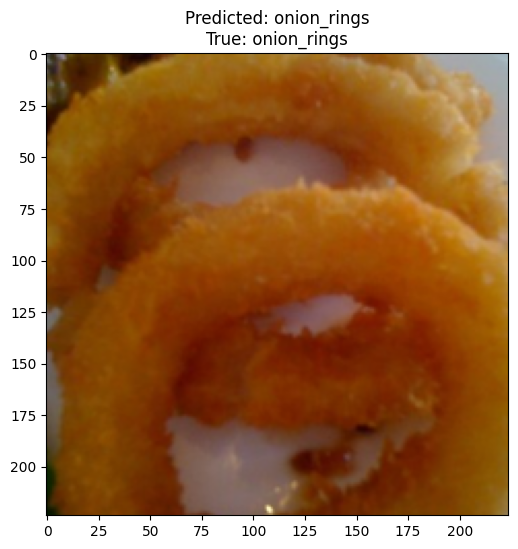

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to visualize the image and prediction
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update plots

# Load a random image from the validation dataset
def demo(model):
    model.eval()
    with torch.no_grad():
        # Randomly pick a sample from the validation dataset
        inputs, labels = next(iter(DataLoader(val_dataset, batch_size=1, shuffle=True)))
        inputs, labels = inputs.to(device), labels.to(device)

        # Make predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Display the image with its predicted label
        plt.figure(figsize=(6, 6))
        imshow(inputs.cpu().data[0], title=f"Predicted: {class_names[preds[0]]}\nTrue: {class_names[labels[0]]}")
        plt.show()

# Run the demo
demo(model)